In [76]:
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.evaluate import lift_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer

In [7]:
train_raw = pd.read_csv('data/contest_train.csv')
test_raw = pd.read_csv('data/contest_test.csv')

print('Shape of train data is ',train.shape)
print('Shape of test data is ',test.shape)

Shape of train data is  (24521, 262)
Shape of test data is  (9484, 261)


In [111]:
n_classes = train_raw.TARGET.unique()
print (f"Unique classes:")
for label in range(len(n_classes)):
    print(f"class_{n_classes[label]}")

Unique classes:
class_1
class_0
class_2


In [109]:
samples_by_class = pd.DataFrame(train_raw.groupby("TARGET", as_index = False)["ID"].count()).sort_values(by="ID",ascending=False).rename(columns = {"ID": "cnt"})
samples_by_class['class']=list(map(lambda x: "class_{}".format(x), samples_by_class.TARGET))

In [110]:
samples_by_class

,TARGET,cnt,class
0,0,17372,class_0
1,1,5650,class_1
2,2,1499,class_2


In [27]:
print(f'{train.isnull().any().sum()} columns in train has NaN')
print(f'{test.isnull().any().sum()} columns in test has NaN')

53 columns in train has NaN
56 columns in test has NaN


In [62]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def lift_score_calc(df, class_, pos_label):
    df = df[df['y_true'].isin(class_)]
    return lift_score(df.y_true, df.pred,  binary=True, positive_label=pos_label)

def f1_for_lgb(y_hat, lgb_train):
    labels = lgb_train.get_label()
    y_hat = y_hat.reshape(-1, len(np.unique(labels))).argmax(axis = 1)
    return ('Metric', f1_score(labels, y_hat, average="macro"), True)

In [31]:
train_data = train_raw.copy()
test_data = test_raw.copy()

In [44]:
cols = [col for col in train_data.columns if (col != 'ID') & (col != 'TARGET')]

In [96]:
X = train_data[cols].copy()
Y = train_data.TARGET.copy()
X_test = test_data.copy().drop(['ID'], axis=1)

X_, X_valid, Y_, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, stratify=Y)


params = {
    'objective' :'multiclass',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'num_class' : 3,
    'n_jobs':-1,
    'seed': 20
}

results = {}
valid_results = []

In [97]:
dtrain = lgb.Dataset(X_, Y_)
dvalid = lgb.Dataset(X_valid, Y_valid)
clf = lgb.train(params, dtrain, 5000,  dvalid, verbose_eval=1000, early_stopping_rounds=15, feval=f1_for_lgb)

Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's multi_logloss: 0.695315	valid_0's Metric: 0.27386
Early stopping, best iteration is:
[292]	valid_0's multi_logloss: 0.641094	valid_0's Metric: 0.276993


In [102]:
predictions_valid = clf.predict(X_valid, num_iteration=clf.best_iteration)
predictions_valid = np.array(predictions_valid.reshape(-1, 3).argmax(axis = 1), np.int)

predictions_test = clf.predict(X_test, num_iteration=clf.best_iteration)
predictions_test = predictions_test.reshape(-1, 3)

valid_results.append(f1_score_calc(Y_valid, predictions_valid))

lift_score_results = pd.DataFrame()
lift_score_results['y_true'] = Y_valid
lift_score_results['pred'] = predictions_valid
print('lift score for 1 2 class: {0:.4f}.'.format(lift_score_calc(lift_score_results, [1, 2], 2)))
print('lift score for 1 0 class: {0:.4f}.'.format(lift_score_calc(lift_score_results, [1, 0], 0)))
print('lift score for 0 2 class: {0:.4f}.'.format(lift_score_calc(lift_score_results, [2, 0], 2)))
print('FINAL score: {0:.4f}.'.format(np.mean(valid_results)))

results['prediction'] = predictions_test 
results['scores'] = valid_results
results['model'] = clf

lift score for 1 2 class: 3.3797.
lift score for 1 0 class: 1.0240.
lift score for 0 2 class: 9.8251.
FINAL score: 0.4576.


### Feature importance

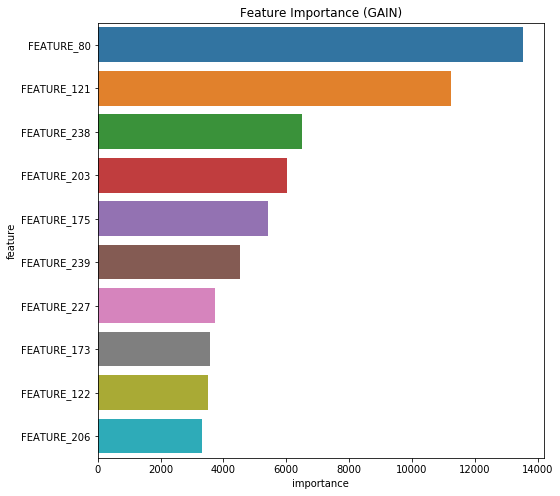

In [118]:
f_imp = pd.DataFrame()
f_imp['importance'] = clf.feature_importance(importance_type='gain')
f_imp['feature'] = clf.feature_name()

top_features = f_imp.sort_values(by='importance', ascending=False)[:10]

plt.figure(figsize=(8, 8));
sns.barplot(x="importance", y="feature", data=top_features);
plt.title('Feature Importance (GAIN)');

In [121]:
submission = test_data.loc[:,['ID']]
submission['TARGET'] =  np.array(predictions_test.argmax(axis = 1), np.int) 
submission.to_csv('contest_answer.csv', index=False)

In [123]:
submission = test_data.loc[:,['ID']]
submission['TARGET'] =  np.array(predictions_test.argmax(axis = 1), np.int) 
submission['proba'] = np.max(predictions_test, axis=1)
first_class = submission[submission['TARGET'] == 1]
second_class = submission[submission['TARGET'] == 2]

In [124]:
second_class.sort_values(by='proba', ascending=False, inplace=True)
second_class = second_class.iloc[0:200, :]
second_class.drop(['proba'], axis=1, inplace=True)
first_class.drop(['proba'], axis=1, inplace=True)
two_class = pd.concat([first_class, second_class], ignore_index=True, sort =False)

In [125]:
two_class.to_csv('contest_segments.csv', index=False)